### OFDM 信號產生
* 1hz 給垂直座標, 2hz 給水平座標, 這樣解碼字典可以減小很多，4k 可以填好
* w_length 是照相看到的一個波長16pixel
* gain2h 是2hz 預先加強，失焦的時候頻率高的衰減比較大，所以RIAA加強
* 2hz 在0 度有很大量化誤差（注意45度的地方）, for hz2phase in range(90,360,90)  的原因

|  1hz   | 2hz  |
|  ----  | ----  |
| 180.0 | -168.0 |
| 180.0 | 90.0 |
| 180.0 | 12.0 |
| 180.0 | -90.0 |
| 90.0 | -168.0 |
| 90.0 | 90.0 |
| 90.0 | 12.0 |
| 90.0 | -90.0 |
| 45.0 | 180.0 |
| 0.0 | 90.0 |
| 0.0 | 12.0 |
| 0.0 | -90.0 |
| -45.0 | 180.0 |
| -90.0 | 90.0 |
| -90.0 | 12.0 |
| -90.0 | -90.0 |

|  1hz   | 2hz  |
|  ----  | ----  |
| -158.0 | 135.0 |
| -158.0 | 57.0 |
| -158.0 | -45.0 |
| 112.0 | 135.0 |
| 112.0 | 57.0 |
| 112.0 | -45.0 |
| 22.0 | 135.0 |
| 23.0 | 57.0 |
| 22.0 | -45.0 |
| -68.0 | 135.0 |
| -68.0 | 57.0 |
| -68.0 | -45.0 |


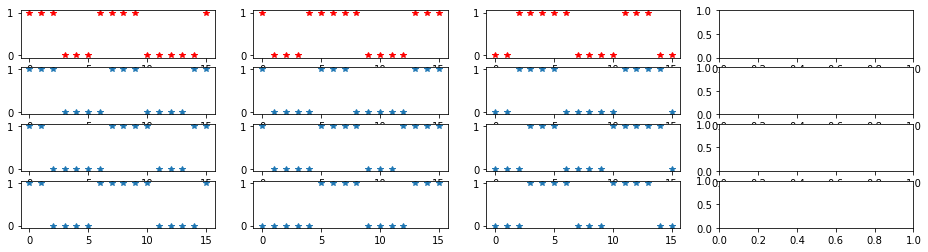

In [173]:
import numpy as np
import matplotlib.pyplot as plt 

w_length=16
gain2h=1.5
def ofdmGen(hz1phase, hz2phase): #hz2phase is degree 
    x=np.arange(w_length)
    y1hz=np.sin(x/w_length*2*np.pi+hz1phase/180*np.pi)
    y2hz=np.sin(x/(w_length/2)*2*np.pi+hz2phase/180*np.pi)
    return (y1hz+y2hz*gain2h)
#plt.plot(y1hz>0)

def getPhase(y):
    cropImg_roll_fft=np.fft.fft(y)
    cropImg_roll_fft_ang=np.arctan2(cropImg_roll_fft.real,cropImg_roll_fft.imag)*180/np.pi
    cropImg_roll_fft_abs=np.abs(cropImg_roll_fft)
    #print(cropImg_roll_fft_abs[[1,2,4]])
    
    return np.round(cropImg_roll_fft_ang[[1,2]])


fig, axs = plt.subplots(4,4, figsize=(16, 4))
plotIndex_1=0
print('|  1hz   | 2hz  |')
print('|  ----  | ----  |')
for hz1phase in range(0,360,90):
    plotIndex_2 = 0
    for hz2phase in range(90,360,90):
        y=ofdmGen(hz1phase, hz2phase)
        y_bw=y>0
        color='*'
        if plotIndex_1 ==0: color='r*'
        axs[plotIndex_1, plotIndex_2].plot(y_bw, color)
        plotIndex_12 += 1
        phase_12=getPhase(np.roll(y_bw,1))
        #print(phase_12)
        print('|',phase_12[0],'|',phase_12[1], '|')

        plotIndex_2 +=1
    plotIndex_1 += 1


plt.show()

#for i in range (361):
    #print(i)
    

### 碼數估算

In [174]:
codeNum=6
v_length=(4**codeNum)*2
v_length

8192

In [184]:
codeNum=6
h_length=(4**codeNum)*9
h_length

36864

### 新增碼文分析
* 原本的碼文是4246
* 新的碼文是4624

#### 2hz 的解碼程序
1. 信號差值在 -30 到 30 度之間，為0相位差
1. 信號差值在 -150 以下 或 150度以上，為180相位差
1. 信號差值在 30 到 150 度之間，為90度相位差
1. 信號差值在 -30 到 -150 度之間，為-90度相位差


In [177]:
c4246=[1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0]
c4462=[0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1]
for i in range(0,16,4):
    print(i,getPhase(np.roll(c4246,i)),getPhase(np.roll(c4462,i+8)<0.5),getPhase(np.roll(c4246,i+8)<0.5),getPhase(np.roll(c4462,i)))


0 [-169.  113.] [-169.  176.] [-169.  -68.] [-169.   -4.]
4 [-79. -68.] [-79.  -4.] [-79. 113.] [-79. 176.]
8 [ 11. 113.] [ 11. 176.] [ 11. -68.] [11. -4.]
12 [101. -68.] [101.  -4.] [101. 113.] [101. 176.]


In [183]:
alist=np.array([113, 176, -68, -4])
for a in alist:
    print(((alist -a)+360)%360-180)

[-180 -117   -1   63]
[ 117 -180  -64    0]
[   1   64 -180 -116]
[ -63    0  116 -180]


### 1Hz碼文產生

In [257]:
def getCode():
    codeSize=4**6
    ocuppy_array=np.zeros(codeSize)
    code_array=np.zeros(codeSize, dtype=int)
    for i in range(codeSize):
        arr = np.arange(4)
        np.random.shuffle(arr)
        conlic=0
        for code in arr:
            #code=getCode()
            code_array[i]=code
            if i>4:
                num=int(code_array[i]*4**5+
                        code_array[i-1]*4**4+
                        code_array[i-2]*4**3+
                        code_array[i-3]*4**2+
                        code_array[i-4]*4**1+
                        code_array[i-5])
                if ocuppy_array[num]==0:
                    ocuppy_array[num]=1
                    #print(num)
                    break
                else:
                    conlic +=1
        if conlic > 3: 
            #print('panic colflict',conlic,i,num)
            break
    return code_array, i

maxcodeLen=0
import pickle

for k in range(1000):
    code_array, codeLen=getCode()
    if codeLen> maxcodeLen:
        maxcodeLen= codeLen
    print(k, codeLen, maxcodeLen)
    if codeLen == 4095:
        # Dump the trained decision tree classifier with Pickle
        code_pkl_filename = '4096code.pkl'
        # Open the file to save as pkl file
        code_pkl_filename_pkl = open(code_pkl_filename, 'wb')
        pickle.dump(code_array, code_pkl_filename_pkl)
        # Close the pickle instances
        code_pkl_filename_pkl.close()
        break
        


0 2428 2428
1 3368 3368
2 2666 3368
3 3618 3618
4 3579 3618
5 3731 3731
6 3334 3731
7 3631 3731
8 3128 3731
9 3927 3927
10 3891 3927
11 3483 3927
12 3295 3927
13 4038 4038
14 4086 4086
15 3352 4086
16 2441 4086
17 3617 4086
18 2741 4086
19 2473 4086
20 3476 4086
21 3216 4086
22 3744 4086
23 3756 4086
24 3185 4086
25 3147 4086
26 3888 4086
27 3687 4086
28 3399 4086
29 2359 4086
30 3978 4086
31 2432 4086
32 3685 4086
33 2459 4086
34 3562 4086
35 3780 4086
36 3820 4086
37 2416 4086
38 2851 4086
39 2497 4086
40 3426 4086
41 3770 4086
42 3309 4086
43 3179 4086
44 3477 4086
45 2838 4086
46 3751 4086
47 3980 4086
48 2716 4086
49 3765 4086
50 3392 4086
51 4088 4088
52 3315 4088
53 3847 4088
54 3216 4088
55 3273 4088
56 4032 4088
57 3437 4088
58 4066 4088
59 3813 4088
60 1983 4088
61 3016 4088
62 4094 4094
63 3700 4094
64 3258 4094
65 2409 4094
66 2841 4094
67 3557 4094
68 2657 4094
69 2346 4094
70 2639 4094
71 3620 4094
72 3919 4094
73 2392 4094
74 2728 4094
75 1869 4094
76 3877 4094
77 3268 4

In [260]:
import pickle
# load the trained decision tree classifier from Pickle
code_pkl_filename = '4096code.pkl'
# Open the file to load as pkl file
with open(file=code_pkl_filename, mode='rb') as f:
    code=pickle.load(f)

print(code)



[2 3 2 ... 3 2 1]
